In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, balanced_accuracy_score
import joblib

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv")

# =========================
# SELECTED FEATURES 
# =========================
FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx',
]

X = df[FEATURES].values
y = df['Label_Impaired'].values

# =========================
# CONFIG
# =========================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=4224)  # Repeated 5x5 CV

scoring_metrics = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

# =========================
# FINAL MODEL PIPELINE
# =========================
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF
    ('rf', RandomForestClassifier(
        n_estimators=500,
        random_state=4224,
        max_depth=5
    ))
])

# =========================
# CROSS-VALIDATED EVALUATION
# =========================
cv_results = cross_validate(final_pipeline, X, y, cv=cv, scoring=scoring_metrics, return_train_score=False)

print("\n--- Final 5-Feature Model Repeated CV Performance ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name[5:]}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# =========================
# TRAIN FINAL MODEL ON FULL DATA
# =========================
final_pipeline.fit(X, y)

# =========================
# FEATURE IMPORTANCE
# =========================
rf_model = final_pipeline.named_steps['rf']
importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)

print("\n--- Feature Importances ---")
print(importances)

# =========================
# SAVE MODEL
# =========================
#joblib.dump(final_pipeline, "PD_MoCA_RF_5Feature_Final.pkl")
print("\nFinal model saved as PD_MoCA_RF_5Feature_Final.pkl")

# Individual fold scores
print(f"Individual Fold AUCs: {cv_results['test_AUC']}")
print(f"Individual Fold Accs: {cv_results['test_Accuracy']}")



--- Final 5-Feature Model Repeated CV Performance ---
AUC: 0.804 ± 0.092
Accuracy: 0.724 ± 0.060
F1: 0.733 ± 0.075
Precision: 0.753 ± 0.088
Recall: 0.737 ± 0.146
BalancedAcc: 0.721 ± 0.060

--- Feature Importances ---
Feature_Theta_Global_Abs             0.262712
Feature_Theta_Asymmetry_Idx          0.208826
Feature_Sync_Delta_ClassA_Frontal    0.206298
Feature_HubPLI_Beta_Delta            0.174051
Feature_DeltaBeta_Global             0.148114
dtype: float64

Final model saved as PD_MoCA_RF_5Feature_Final.pkl
Individual Fold AUCs: [0.87878788 0.67676768 0.92929293 0.82       0.78       0.88888889
 0.82828283 0.76767677 0.82       0.81       0.56565657 0.90909091
 0.64646465 0.81       0.83       0.8989899  0.94949495 0.70707071
 0.69       0.76       0.88888889 0.76767677 0.83838384 0.87
 0.76      ]
Individual Fold Accs: [0.85 0.7  0.8  0.7  0.7  0.7  0.75 0.65 0.8  0.75 0.65 0.7  0.65 0.7
 0.7  0.8  0.85 0.65 0.65 0.65 0.75 0.75 0.75 0.75 0.7 ]


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
MAX_FEATURES = 6
# ============================================================
# 1. DATA SPLITTING — 80/20, Test Set Locked Away
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"Data Split: Train={len(X_train)} | Test={len(X_test)}")

# ============================================================
# 2. FORWARD FEATURE SELECTION (CV on Train only)
# Uses 5-fold stratified CV instead of a single val set
# — much more stable estimates, no data wasted
# ============================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

selected_idx = []
remaining_idx = list(range(X.shape[1]))
best_auc = 0.0

print("\n--- Running Forward Selection (5-Fold CV) ---")

for step in range(MAX_FEATURES):
    step_results = []

    for i in remaining_idx:
        trial_idx = selected_idx + [i]

        # Pipeline handles scaler + model inside each CV fold — no leakage
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", RandomForestClassifier(
                n_estimators=300,
                max_depth=5,
                class_weight="balanced",
                random_state=RANDOM_STATE,
                n_jobs=-1
            ))
        ])

        scores = cross_val_score(
            pipe,
            X_train[:, trial_idx],
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        step_results.append((i, scores.mean()))

    best_i, best_step_auc = max(step_results, key=lambda x: x[1])

    if best_step_auc <= best_auc + 1e-4:
        print("No further improvement — stopping.")
        break

    selected_idx.append(best_i)
    remaining_idx.remove(best_i)
    best_auc = best_step_auc
    print(f"Step {step+1}: Added '{FEATURES[best_i]}' | CV AUC: {best_auc:.4f}")

# ============================================================
# 3. FINAL MODEL — Retrain on ALL train data, evaluate on test
# ============================================================
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

pipe_final.fit(X_train[:, selected_idx], y_train)

final_probs = pipe_final.predict_proba(X_test[:, selected_idx])[:, 1]
final_preds = pipe_final.predict(X_test[:, selected_idx])

auc = roc_auc_score(y_test, final_probs)
acc = accuracy_score(y_test, final_preds)
f1  = f1_score(y_test, final_preds)

print("\n" + "=" * 45)
print(f"SELECTED FEATURES : {FEATURES[selected_idx].tolist()}")
print(f"TEST AUC          : {auc:.4f}")
print(f"TEST ACCURACY     : {acc:.4f}")
print(f"TEST F1           : {f1:.4f}")
print("=" * 45)

Data Split: Train=80 | Test=20

--- Running Forward Selection (5-Fold CV) ---
Step 1: Added 'Feature_HubPLI_Beta_Delta' | CV AUC: 0.6930
Step 2: Added 'Feature_Theta_Global_Abs' | CV AUC: 0.7390
Step 3: Added 'Feature_Theta_Asymmetry_Idx' | CV AUC: 0.7576
No further improvement — stopping.



TypeError: list indices must be integers or slices, not list


--- Global SHAP Feature Importance (raw) ---
Feature_Theta_Global_Abs             0.101576
Feature_Theta_Asymmetry_Idx          0.083607
Feature_Sync_Delta_ClassA_Frontal    0.068456
Feature_HubPLI_Beta_Delta            0.057596
Feature_DeltaBeta_Global             0.054877
dtype: float64

--- Global SHAP Feature Importance (%) ---
Feature_Theta_Global_Abs             27.744631
Feature_Theta_Asymmetry_Idx          22.836421
Feature_Sync_Delta_ClassA_Frontal    18.698073
Feature_HubPLI_Beta_Delta            15.731769
Feature_DeltaBeta_Global             14.989106
dtype: float64


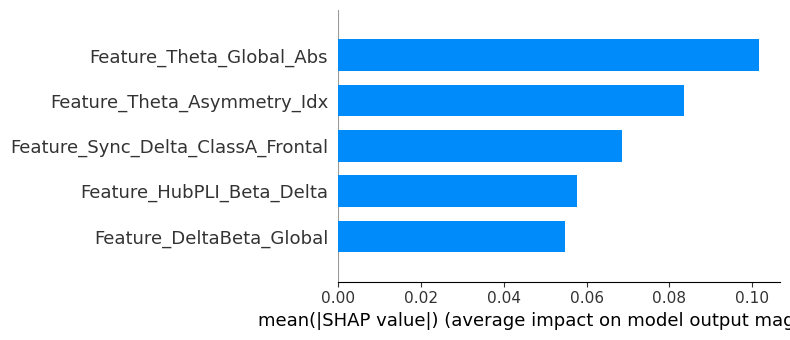

In [4]:
# =========================
# SHAP ANALYSIS (FINAL, FIXED)
# =========================
import shap

rf_model = final_pipeline.named_steps['rf']
scaler = final_pipeline.named_steps['scaler']

# Scale features exactly as used in training
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_scaled_df)

# ---- HANDLE SHAP OUTPUT FORMAT SAFELY ----
# Case 1: New SHAP (array: n_samples x n_features x n_classes)
if isinstance(shap_values, np.ndarray):
    # Positive class = index 1
    shap_vals_pos = shap_values[:, :, 1]

# Case 2: Old SHAP (list of arrays)
else:
    shap_vals_pos = shap_values[1]

# ---- GLOBAL SHAP IMPORTANCE ----
shap_importance = pd.Series(
    np.mean(np.abs(shap_vals_pos), axis=0),
    index=FEATURES
).sort_values(ascending=False)

shap_importance_pct = 100 * shap_importance / shap_importance.sum()

print("\n--- Global SHAP Feature Importance (raw) ---")
print(shap_importance)

print("\n--- Global SHAP Feature Importance (%) ---")
print(shap_importance_pct)

# Optional visualization
shap.summary_plot(
    shap_vals_pos,
    X_scaled_df,
    plot_type="bar",
    show=True
)


--- Global SHAP Feature Importance (raw) ---
Feature_Theta_Global_Abs             0.101576
Feature_Theta_Asymmetry_Idx          0.083607
Feature_Sync_Delta_ClassA_Frontal    0.068456
Feature_HubPLI_Beta_Delta            0.057596
Feature_DeltaBeta_Global             0.054877
dtype: float64

--- Global SHAP Feature Importance (%) ---
Feature_Theta_Global_Abs             27.744631
Feature_Theta_Asymmetry_Idx          22.836421
Feature_Sync_Delta_ClassA_Frontal    18.698073
Feature_HubPLI_Beta_Delta            15.731769
Feature_DeltaBeta_Global             14.989106
dtype: float64


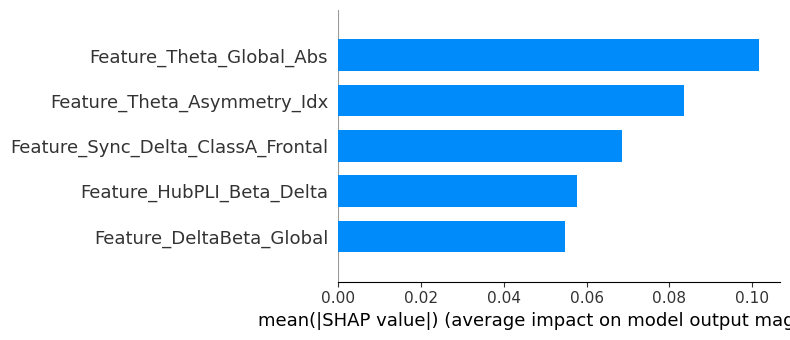

In [5]:
# ---- HANDLE SHAP OUTPUT FORMAT SAFELY ----
# Case 1: New SHAP (array: n_samples x n_features x n_classes)
if isinstance(shap_values, np.ndarray):
    # Negative class = index 0
    shap_vals_neg = shap_values[:, :, 0]

# Case 2: Old SHAP (list of arrays)
else:
    shap_vals_neg = shap_values[0]

# ---- GLOBAL SHAP IMPORTANCE ----
shap_importance = pd.Series(
    np.mean(np.abs(shap_vals_neg), axis=0),
    index=FEATURES
).sort_values(ascending=False)

shap_importance_pct = 100 * shap_importance / shap_importance.sum()

print("\n--- Global SHAP Feature Importance (raw) ---")
print(shap_importance)

print("\n--- Global SHAP Feature Importance (%) ---")
print(shap_importance_pct)

shap.summary_plot(
    shap_vals_neg,
    X_scaled_df,
    plot_type="bar",
    show=True
)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, balanced_accuracy_score
import joblib

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv")

# =========================
# SELECTED FEATURES 
# =========================
FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx',
]

X = df[FEATURES].values
y = df['Label_Impaired'].values

# =========================
# CONFIG
# =========================
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=20, random_state=4224)  # Repeated 5x5 CV

scoring_metrics = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

# =========================
# FINAL MODEL PIPELINE
# =========================
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF
    ('rf', RandomForestClassifier(
        n_estimators=500,
        random_state=4224,
        max_depth=10
    ))
])

# =========================
# CROSS-VALIDATED EVALUATION
# =========================
cv_results = cross_validate(final_pipeline, X, y, cv=cv, scoring=scoring_metrics, return_train_score=False)

print("\n--- Final 5-Feature Model Repeated CV Performance ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name[5:]}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# =========================
# TRAIN FINAL MODEL ON FULL DATA
# =========================
final_pipeline.fit(X, y)

# =========================
# FEATURE IMPORTANCE
# =========================
rf_model = final_pipeline.named_steps['rf']
importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)

print("\n--- Feature Importances ---")
print(importances)

# =========================
# SAVE MODEL
# # =========================
# joblib.dump(final_pipeline, "PD_MoCA_RF_5Feature_Final.pkl")
# print("\nFinal model saved as PD_MoCA_RF_5Feature_Final.pkl")

# Individual fold scores
print(f"Individual Fold AUCs: {cv_results['test_AUC']}")
print(f"Individual Fold Accs: {cv_results['test_Accuracy']}")



--- Final 5-Feature Model Repeated CV Performance ---
AUC: 0.784 ± 0.083
Accuracy: 0.700 ± 0.083
F1: 0.708 ± 0.084
Precision: 0.737 ± 0.099
Recall: 0.695 ± 0.118
BalancedAcc: 0.700 ± 0.083

--- Feature Importances ---
Feature_Theta_Global_Abs             0.252501
Feature_Sync_Delta_ClassA_Frontal    0.210059
Feature_Theta_Asymmetry_Idx          0.201642
Feature_HubPLI_Beta_Delta            0.179760
Feature_DeltaBeta_Global             0.156038
dtype: float64
Individual Fold AUCs: [0.74025974 0.80769231 0.89102564 0.75641026 0.87662338 0.82051282
 0.75       0.73076923 0.68181818 0.76923077 0.68589744 0.85897436
 0.91558442 0.80128205 0.66666667 0.75961538 0.87662338 0.78205128
 0.78205128 0.83333333 0.59090909 0.73076923 0.83012821 0.83333333
 0.78571429 0.62820513 0.79487179 0.78846154 0.80519481 0.80769231
 0.76282051 0.77564103 0.75324675 0.92307692 0.68589744 0.81410256
 0.7987013  0.77564103 0.63461538 0.78846154 0.96103896 0.77564103
 0.49358974 0.86538462 0.81493506 0.77564103 

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=4224)

results = []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=500, random_state=4224, max_depth=5))
    ])
    
    pipeline.fit(X_train, y_train)
    # compute your metrics on X_test, y_test
    # append to results

Text(0.5, 1.0, 'Cross-Validated 5x5 Confusion Matrix (%)')

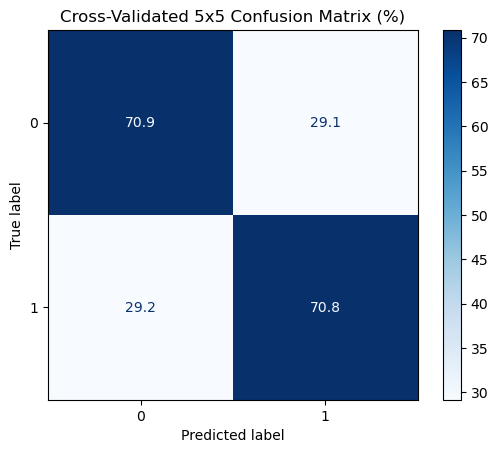

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =========================
# CROSS-VALIDATED PREDICTIONS
# =========================
y_true_all = []
y_pred_all = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit pipeline on training fold
    final_pipeline.fit(X_train, y_train)

    # Predict on test fold
    y_pred = final_pipeline.predict(X_test)

    # Store for combined confusion matrix
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# =========================
# CROSS-VALIDATED CONFUSION MATRIX (Percent)
# =========================
cm_cv = confusion_matrix(y_true_all, y_pred_all, normalize='true')*100   # convert to percentages
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=final_pipeline.named_steps['rf'].classes_)
disp_cv.plot(cmap='Blues', values_format=".1f")  # one decimal place
disp_cv.ax_.set_title("Cross-Validated 5x5 Confusion Matrix (%)")


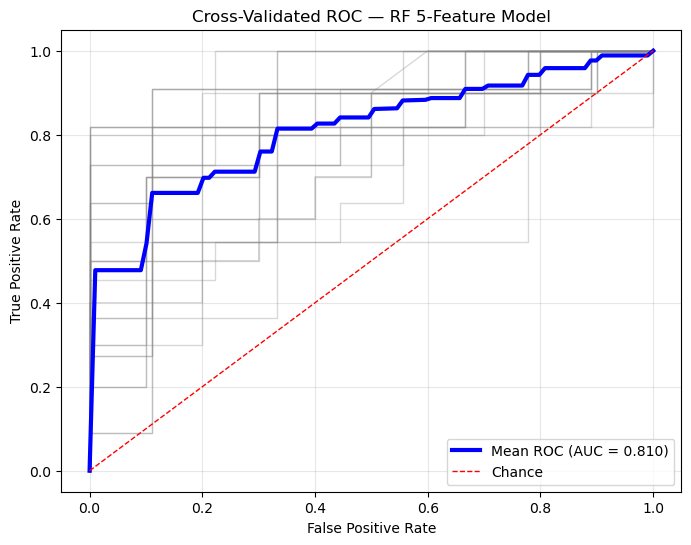

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import joblib

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=4224)

plt.figure(figsize=(8,6))
all_fpr = np.linspace(0, 1, 100)
tprs = []

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    final_pipeline.fit(X_train, y_train)
    y_proba = final_pipeline.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    tprs.append(np.interp(all_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    plt.plot(fpr, tpr, color='gray', alpha=0.3, lw=1)

# Mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color='blue', lw=3, label=f'Mean ROC (AUC = {mean_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC — RF 5-Feature Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [8]:
# =========================
# PERMUTATION (LABEL-SHUFFLE) TEST
# =========================
N_PERM = 100 # 100 is minimum; 500–1000 is better for  rigor

perm_auc = []
perm_acc = []

rng = np.random.default_rng(4224)

for i in range(N_PERM):
    y_perm = rng.permutation(y)  # shuffle labels ONLY
    
    perm_results = cross_validate(
        final_pipeline,
        X,
        y_perm,
        cv=cv,
        scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
        return_train_score=False
    )
    
    perm_auc.append(np.mean(perm_results['test_AUC']))
    perm_acc.append(np.mean(perm_results['test_Accuracy']))

perm_auc = np.array(perm_auc)
perm_acc = np.array(perm_acc)

print("\n--- Permutation Test Results ---")
print(f"AUC (null): {perm_auc.mean():.3f} ± {perm_auc.std():.3f}")
print(f"Accuracy (null): {perm_acc.mean():.3f} ± {perm_acc.std():.3f}")



--- Permutation Test Results ---
AUC (null): 0.494 ± 0.081
Accuracy (null): 0.497 ± 0.058


In [14]:
real_auc = np.mean(cv_results['test_AUC'])
real_acc = np.mean(cv_results['test_Accuracy'])

p_auc = np.mean(perm_auc >= real_auc)
p_acc = np.mean(perm_acc >= real_acc)

print("\n--- Empirical p-values ---")
print(f"AUC p-value: {p_auc:.70f}")
print(f"Accuracy p-value: {p_acc:.4f}")



--- Empirical p-values ---
AUC p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000
Accuracy p-value: 0.0000


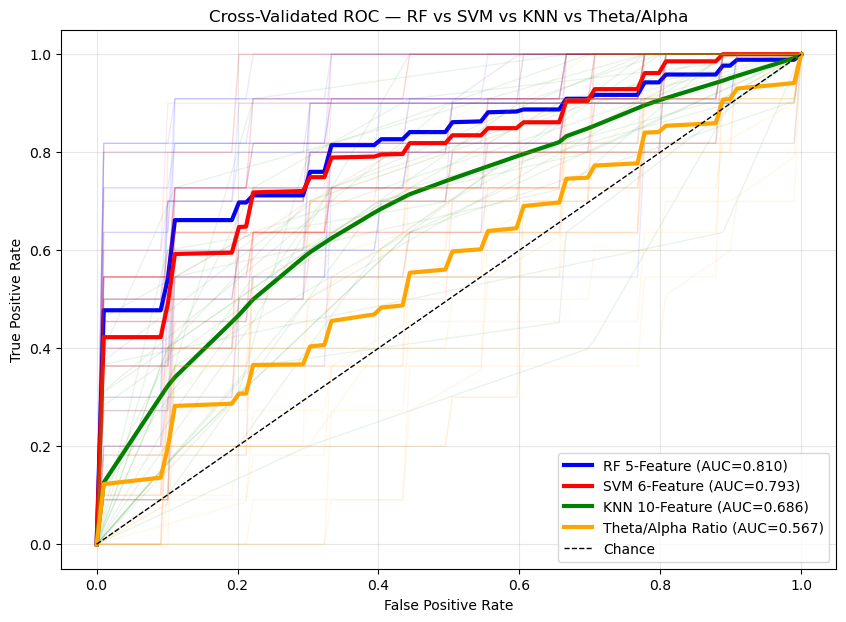

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import joblib

# =========================
# LOAD DATA
# =========================
df = pd.read_csv("ML_Feature_Matrix.csv")
y = df['Label_Impaired'].values

# =========================
# FEATURE SETS
# =========================
RF_FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx',
]

SVM_FEATURES = [
    'Feature_Instab_Delta_occurrence_Var',
    'Feature_HubPLI_Beta_Frontal',
    'Feature_Instab_Delta_coverage_CV',
    'Feature_Theta_Asymmetry_Idx',
    'Feature_DWT_Theta_over_alpha_frac',
    'Feature_Gamma_Posterior_Abs',
]

KNN_FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx',
    'Feature_Instab_Delta_occurrence_Var',
    'Feature_HubPLI_Beta_Frontal',
    'Feature_Instab_Delta_coverage_CV',
    'Feature_DWT_Theta_over_alpha_frac',
    'Feature_Gamma_Posterior_Abs',
]

THETA_ALPHA_FEATURE = ['Feature_ThetaAlpha_Global']

# =========================
# CROSS-VALIDATION CONFIG
# =========================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=4224)
all_fpr = np.linspace(0, 1, 100)

# =========================
# PLOT INIT
# =========================
plt.figure(figsize=(10,7))

# =========================
# FUNCTION TO PLOT ROC
# =========================
def plot_model_roc(X, y, pipeline, label, color):
    tprs = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        tpr_interp = np.interp(all_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color=color, lw=3, label=f'{label} (AUC={mean_auc:.3f})')
    # optional: plot individual fold curves lightly
    for tpr in tprs:
        plt.plot(all_fpr, tpr, color=color, alpha=0.085, lw=1)
    return pipeline

# =========================
# RANDOM FOREST PIPELINE
# =========================
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=10, random_state=4224))
])
X_rf = df[RF_FEATURES].values
rf_pipeline = plot_model_roc(X_rf, y, rf_pipeline, label='RF 5-Feature', color='blue')

# =========================
# SVM PIPELINE
# =========================
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42))
])
X_svm = df[SVM_FEATURES].values
svm_pipeline = plot_model_roc(X_svm, y, svm_pipeline, label='SVM 6-Feature', color='red')

# =========================
# KNN PIPELINE (k=3)
# =========================
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])
X_knn = df[KNN_FEATURES].values
knn_pipeline = plot_model_roc(X_knn, y, knn_pipeline, label='KNN 10-Feature', color='green')

# =========================
# Theta/Alpha ratio-only model (RF)
# =========================
theta_alpha_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42))
])
X_theta_alpha = df[THETA_ALPHA_FEATURE].values
theta_alpha_pipeline = plot_model_roc(X_theta_alpha, y, theta_alpha_pipeline, label='Theta/Alpha Ratio', color='orange')

# =========================
# PLOT FINAL TOUCHES
# =========================
plt.plot([0,1],[0,1], color='black', linestyle='--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC — RF vs SVM vs KNN vs Theta/Alpha')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =========================
# SAVE MODELS
# =========================
# joblib.dump(rf_pipeline, "PD_MoCA_RF_5Feature_Final.pkl")
# joblib.dump(svm_pipeline, "PD_MoCA_SVM_6Feature_Final.pkl")
# joblib.dump(knn_pipeline, "PD_MoCA_KNN_10Feature_Final.pkl")
# joblib.dump(theta_alpha_pipeline, "PD_MoCA_ThetaAlpha_RF_Final.pkl")
# print("All models saved.")


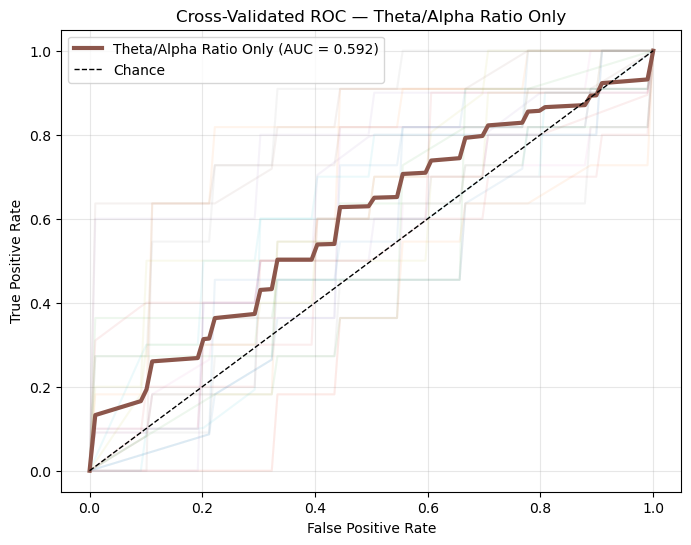

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

# =========================
# LOAD DATA
# =========================
df = pd.read_csv("ML_Feature_Matrix.csv")
y = df['Label_Impaired'].values

# HARD-CODED SINGLE FEATURE (Theta/Alpha Ratio)
X = df[['Feature_DWT_Theta_over_alpha_frac']].values

# =========================
# CROSS-VALIDATION
# =========================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=4224)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# =========================
# MODEL (simple + constrained)
# =========================
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=4,
        random_state=4224
    ))
])

# =========================
# CV ROC COMPUTATION
# =========================
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline.fit(X_train, y_train)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# =========================
# MEAN ROC
# =========================
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# =========================
# PLOT
# =========================
plt.figure(figsize=(8,6))
for tpr in tprs:
    plt.plot(mean_fpr, tpr, alpha=0.08)

plt.plot(mean_fpr, mean_tpr, lw=3, label=f'Theta/Alpha Ratio Only (AUC = {mean_auc:.3f})')
plt.plot([0,1],[0,1],'k--', lw=1, label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC — Theta/Alpha Ratio Only')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
